In [1]:
from fixedpoint import FixedPoint
import gzip
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import torch

sys.path.append('./sw/')

NEURAL_NETWORK_PATH = "./sw/models/bnn_e01_SNR20_0.pt"
MEM_FILE_PATH = "./mem_files/for_testbench/fully_parallel_16_3"
INPUT_SIGNALS_PATH = "./sw/data/signals/infer_20SNR.pickle.gz"
ACCELERATOR_NUM_LANES = 11
accelerator_perceptrons = [[] for _ in range(ACCELERATOR_NUM_LANES)]
TOTAL_BITS = 16
MEMORY_WIDTH = 128 + 1
PAD_WITH_ZEROS = True
INT_BITS = 3

In [6]:
net: torch.nn.Module = torch.load(NEURAL_NETWORK_PATH, map_location="cpu")
net.eval()
dict(net.named_parameters()).keys()

dict_keys(['fc_layers.0.0.weight', 'fc_layers.0.0.bias', 'fc_layers.0.1.p', 'fc_layers.0.1.multiplier', 'fc_layers.0.2.weight', 'fc_layers.0.2.bias', 'fc_layers.0.4.weight', 'fc_layers.0.4.bias', 'fc_layers.0.5.p', 'fc_layers.0.5.multiplier', 'fc_layers.0.6.weight', 'fc_layers.0.6.bias', 'fc_layers.1.0.weight', 'fc_layers.1.0.bias', 'fc_layers.1.1.p', 'fc_layers.1.1.multiplier', 'fc_layers.1.2.weight', 'fc_layers.1.2.bias', 'fc_layers.1.4.weight', 'fc_layers.1.4.bias', 'fc_layers.1.5.p', 'fc_layers.1.5.multiplier', 'fc_layers.1.6.weight', 'fc_layers.1.6.bias', 'fc_layers.2.0.weight', 'fc_layers.2.0.bias', 'fc_layers.2.1.p', 'fc_layers.2.1.multiplier', 'fc_layers.2.2.weight', 'fc_layers.2.2.bias', 'fc_layers.2.4.weight', 'fc_layers.2.4.bias', 'fc_layers.2.5.p', 'fc_layers.2.5.multiplier', 'fc_layers.2.6.weight', 'fc_layers.2.6.bias', 'fc_layers.3.0.weight', 'fc_layers.3.0.bias', 'fc_layers.3.1.p', 'fc_layers.3.1.multiplier', 'fc_layers.3.2.weight', 'fc_layers.3.2.bias', 'fc_layers.3.4.w

In [7]:
import torch.quantization

to_fuse = []
for param_net in range(4):
    for offset in [0, 4]:
        to_fuse.append([f"fc_layers.{param_net}.{offset}", f"fc_layers.{param_net}.{offset+2}"])
to_fuse

[['fc_layers.0.0', 'fc_layers.0.2'],
 ['fc_layers.0.4', 'fc_layers.0.6'],
 ['fc_layers.1.0', 'fc_layers.1.2'],
 ['fc_layers.1.4', 'fc_layers.1.6'],
 ['fc_layers.2.0', 'fc_layers.2.2'],
 ['fc_layers.2.4', 'fc_layers.2.6'],
 ['fc_layers.3.0', 'fc_layers.3.2'],
 ['fc_layers.3.4', 'fc_layers.3.6']]

In [8]:
fnet = torch.ao.quantization.fuse_modules(net, to_fuse)
fnet

Net(
  (fc_layers): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=11, out_features=11, bias=True)
      (1): BernoulliDropout(
        p=0.10000000149011612, quant=False
        (mul_mask): FloatFunctional(
          (activation_post_process): Identity()
        )
        (mul_scalar): FloatFunctional(
          (activation_post_process): Identity()
        )
      )
      (2): Identity()
      (3): ReLU()
      (4): Linear(in_features=11, out_features=11, bias=True)
      (5): BernoulliDropout(
        p=0.10000000149011612, quant=False
        (mul_mask): FloatFunctional(
          (activation_post_process): Identity()
        )
        (mul_scalar): FloatFunctional(
          (activation_post_process): Identity()
        )
      )
      (6): Identity()
      (7): ReLU()
    )
    (1): ModuleList(
      (0): Linear(in_features=11, out_features=11, bias=True)
      (1): BernoulliDropout(
        p=0.10000000149011612, quant=False
        (mul_mask): FloatFunctional(
 

In [19]:
w = fnet.get_submodule("fc_layers.0.0").weight
w

Parameter containing:
tensor([[-0.1466, -0.0679, -0.1001,  0.0206,  0.0925,  0.1804,  0.1793,  0.2372,
          0.0158, -0.0948, -0.1375],
        [-0.1564, -0.1306,  0.0091,  0.1329,  0.1761,  0.1782,  0.1613,  0.0768,
         -0.0147, -0.1107, -0.0813],
        [-0.2867,  0.1139,  0.4292,  0.4980,  0.2934,  0.0335, -0.3622, -0.6779,
         -0.2407,  0.1394,  0.3257],
        [-0.1790, -0.1774,  0.0055,  0.1482,  0.1923,  0.1882,  0.1702,  0.0565,
         -0.0070, -0.0383, -0.0806],
        [-0.0481, -0.2398, -0.2070, -0.0825,  0.0515,  0.1613,  0.3076,  0.3591,
          0.1162, -0.1055, -0.2051],
        [-0.1034, -0.2271, -0.1266, -0.0064,  0.1055,  0.1596,  0.2576,  0.2495,
          0.0535, -0.0975, -0.1768],
        [-0.1009,  0.2461,  0.1606, -0.0380, -0.1558, -0.2489, -0.3079, -0.2395,
         -0.0164,  0.1214,  0.1546],
        [ 0.5570,  0.0866, -0.1107, -0.2272, -0.2177, -0.1718, -0.0809,  0.0262,
          0.0396,  0.0345,  0.0391],
        [ 0.1152,  0.3621,  0.2031

In [20]:
b = fnet.get_submodule("fc_layers.0.0").bias
b

Parameter containing:
tensor([-0.1247, -0.1465, -0.2355, -0.1328,  0.0221, -0.0586,  0.3163, -0.0911,
        -0.0591,  0.0584, -0.0675], requires_grad=True)

In [17]:
rt, ot = torch.rand(11), torch.ones(11)
rt

tensor([0.5520, 0.9768, 0.9018, 0.1055, 0.2380, 0.4723, 0.9905, 0.6419, 0.1400,
        0.2897, 0.3356])

In [18]:
fnet.get_submodule("fc_layers.0.0")(ot)

tensor([ 0.0541,  0.0942,  0.0300,  0.1458,  0.1298,  0.0294, -0.1084, -0.1165,
        -0.1776,  0.1416,  0.2521], grad_fn=<AddBackward0>)

In [23]:
for i in range(11):
    print(float(ot @ w[i] + b[i]), end=' ')

0.05408957600593567 0.09417036175727844 0.030044883489608765 0.1457900106906891 0.1297684758901596 0.029368653893470764 -0.10836350917816162 -0.1164596900343895 -0.17759409546852112 0.14156444370746613 0.2520504593849182 

In [32]:
INPUT_SIGNALS_PATH = "./sw/data/signals/infer_20SNR.pickle.gz"
with gzip.open(INPUT_SIGNALS_PATH, "rb") as fd:
        X, dpgt, fpgt, dt = pickle.load(fd)

In [52]:
Ps = fnet(torch.from_numpy(X.astype(np.float32)))
Xout = Ps[0]

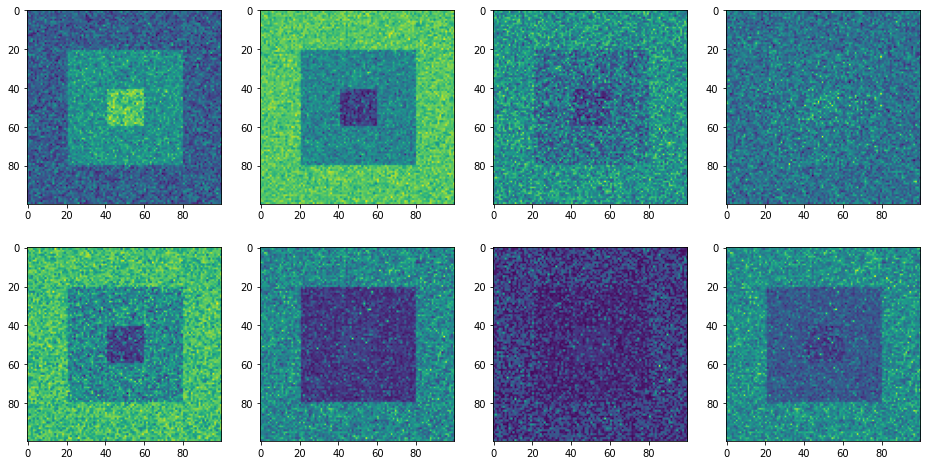

In [53]:
fig, ax = plt.subplots(2,4,figsize=(16,8))
for i,v in enumerate(Ps[1:]):
    ax[0,i].imshow(torch.mean(v, axis=0).detach().cpu().numpy().reshape(100,100))
    ax[1,i].imshow(torch.std(v, axis=0).detach().cpu().numpy().reshape(100,100))
plt.show()

In [54]:
[np.mean(g.reshape(10000,1) - e.detach().cpu().numpy()) for g,e in zip([dpgt, fpgt, dt], Ps[1:4])]

[-5.787427589980815e-05, 0.003404929505658516, -0.00606849700212658]

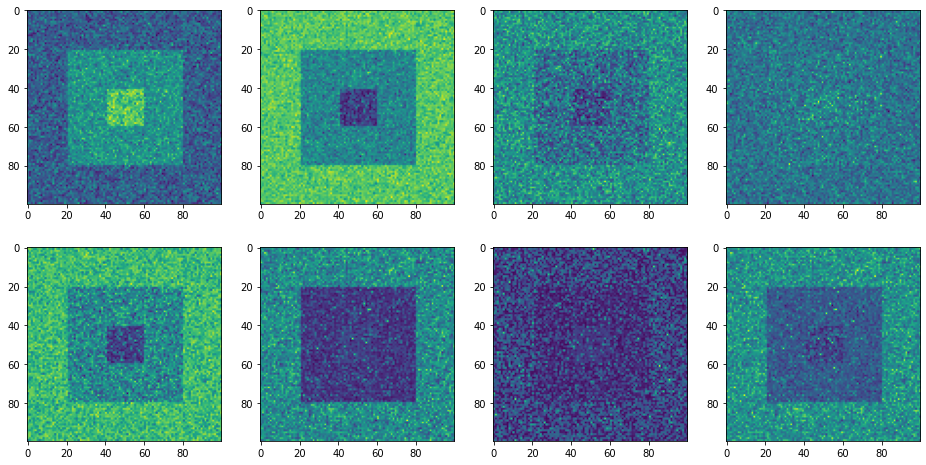

In [55]:
Ps = net(torch.from_numpy(X.astype(np.float32)))
Xout = Ps[0]
fig, ax = plt.subplots(2,4,figsize=(16,8))
for i,v in enumerate(Ps[1:]):
    ax[0,i].imshow(torch.mean(v, axis=0).detach().cpu().numpy().reshape(100,100))
    ax[1,i].imshow(torch.std(v, axis=0).detach().cpu().numpy().reshape(100,100))
plt.show()

In [56]:
[np.mean(g.reshape(10000,1) - e.detach().cpu().numpy()) for g,e in zip([dpgt, fpgt, dt], Ps[1:4])]

[-5.784119339934285e-05, 0.003410156144999497, -0.006070873241329512]